## Parameters Estimation

The solution to the parameters estimation problem is to maximize the log-likelihood function $\log p(x) = \sum_{i=1}^K \log (p(x_i) | pa(x_i), \theta_i)$, with $pa()$ be the parent models.

Consider the data $(X_1, X_2)$, where $X_1$ is 6-dimension vector sampled according to $N(0,I_6)$, and $X_2 = [x_{2,1},x_{2,2},...,x_{2,6}]$ is 6-dimension vector sampled according: 
$$p(X_2) \propto \exp(\Sigma_{i=1}^{6} x_{2,i}^4 - \Sigma_{1 \leq i<j \leq 6} x_{2,i}^2 x_{2,j}^2)$$

Let $x_3 = 10 * sigmoid(X_1 A_1  + X_2 A_2) + N(0,I_4)$, where 
$$A_1 =
\begin{bmatrix} 
0.5 & 0   & 0   & 0\\
0.5 & 0.5 & 0   & 0\\
0   & 0.5 & 0.5 & 0\\
0   & 0   & 0.5 & 0.5 \\
0   & 0   & 0   & 0.5\\
0   & 0   & 0   & 0\\
\end{bmatrix}, 
A_2 = \begin{bmatrix} 
1/3 & 0   & 0   & 0\\
1/3 & 1/3 & 0   & 0\\
1/3 & 1/3 & 1/3 & 0\\
0   & 1/3 & 1/3 & 1/3 \\
0   & 0   & 1/3 & 1/3\\
0   & 0   & 0   & 1/3
\end{bmatrix}
$$

Generate 100,000 sample of $(X_1, X_2, X_3)$. Assume we are only given these samples above and we want to learn the pdf of $p(X_1)p(X_2)p(X_3|X_1, X_2)$. For the corresponding graphical model of $X_1, X_2, X_3$ given above, model $p(X_1),p(X_2),p(X_3|X_1, X_2)$ using Normalizing Flows (NF) for $X_1, X_2$ and a conditional NF for $X_3$. You can reuse the coupling NF models from HW1 Problem 1.

Design, train and optimize these NFs and estimate the corresponding distributions.

I'm gonna modify this paper for conditional flow: https://arxiv.org/pdf/1912.00042.pdf (LEARNING LIKELIHOODS WITH CONDITIONAL NORMALIZING FLOWS)

Architectures

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# NF architectures

class CouplingLayerD(nn.Module):
    def __init__(self, in_features, mid_features, out_features, mask):
        super(CouplingLayerD, self).__init__()
        self.mask = mask
        self.scale = nn.Sequential(
            nn.Linear(in_features, mid_features),
            nn.ReLU(),
            nn.Linear(mid_features, mid_features),
            nn.ReLU(),
            nn.Linear(mid_features, out_features),
            nn.Tanh()
        )
        self.translation = nn.Sequential(
            nn.Linear(in_features, mid_features),
            nn.ReLU(),
            nn.Linear(mid_features, mid_features),
            nn.ReLU(),
            nn.Linear(mid_features, out_features)
        )

    def forward(self, x):
        if self.mask != None:
            masked_x = x * self.mask
        else:
            masked_x = x
        scale = self.scale(masked_x)
        translation = self.translation(masked_x)
        if self.mask != None:
            y = masked_x + (1 - self.mask) * (x * torch.exp(scale) + translation)
            log_det = torch.sum(scale * (1 - self.mask), dim=1)
        else:
            y = masked_x + (x * torch.exp(scale) + translation)
            log_det = torch.sum(scale, dim=1)
        return y, log_det

class NormalizingFlow(nn.Module):
    def __init__(self, in_features, hidden_features, num_layers):
        super(NormalizingFlow, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_layers = num_layers
        self.mask = self._create_mask(in_features)
        self.flow = self._create_flow()

    def _create_mask(self, in_features):
        mask = torch.zeros(in_features)
        mask[:in_features // 2] = 1
        return mask

    def _create_flow(self):
        layers = []
        for _ in range(self.num_layers):
            layers.append(CouplingLayerD(self.in_features, self.hidden_features, self.in_features, self.mask))
            self.mask = 1 - self.mask
        return nn.ModuleList(layers)

    def forward(self, x):
        log_det = torch.zeros(x.size(0))
        for layer in self.flow:
            x, ld = layer(x)
            log_det += ld
        return x, log_det

# Conditional NF for X3 given X1 and X2
import torch.nn.functional as F

class RRDB(nn.Module):
    def __init__(self, in_features, out_features, num_blocks, num_features):
        super(RRDB, self).__init__()
        self.fc_blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.fc_blocks.append(RRDBFCBlock(in_features, out_features, num_features))

    def forward(self, x):
        out = x
        for block in self.fc_blocks:
            out = block(out)
        return out

class RRDBFCBlock(nn.Module):
    def __init__(self, in_features, out_features, num_features):
        super(RRDBFCBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, num_features)
        self.fc2 = nn.Linear(num_features, num_features)
        self.fc3 = nn.Linear(num_features, out_features)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        out = out + x
        return out

class ConditionalFlow(nn.Module):
    def __init__(self, in_features, hidden_features, num_layers, num_subflows, num_levels):
        super(ConditionalFlow, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_layers = num_layers
        self.num_subflows = num_subflows
        self.num_levels = num_levels
        self.flow = self._create_flow()

    def _create_flow(self):
        layers = []
        for _ in range(self.num_levels):
            level_layers = []
            for _ in range(self.num_subflows):
                level_layers.append(SubFlow(self.in_features, self.hidden_features, self.num_layers))
            layers.append(nn.ModuleList(level_layers))
            self.in_features //= 2  # Factor out half of the features at each level
        return nn.ModuleList(layers)

    def forward(self, x, conditioning_variable):
        h = self._transform_conditioning_variable(conditioning_variable)
        log_det = torch.zeros(x.size(0))
        for level in self.flow:
            for subflow in level:
                x, ld = subflow(x, h)
                log_det += ld
        return x, log_det

    def _transform_conditioning_variable(self, x):
        transformer = RRDB(4, 4, 3, 6)
        x = transformer(x)
        pass

class SubFlow(nn.Module):
    def __init__(self, in_features, hidden_features, num_layers):
        super(SubFlow, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_layers = num_layers
        self.flow = self._create_flow()

    def _create_flow(self):
        layers = []
        for _ in range(self.num_layers):
            layers.append(CouplingLayer(self.in_features, self.hidden_features))
        return nn.ModuleList(layers)

    def forward(self, x, conditioning_variable):
        log_det = torch.zeros(x.size(0))
        for layer in self.flow:
            x, ld = layer(x, conditioning_variable)
            log_det += ld
        return x, log_det

class CouplingLayer(nn.Module):
    def __init__(self, in_features, hidden_features):
        super(CouplingLayer, self).__init__()
        self.scale = nn.Sequential(
            nn.Conv1d(in_features, hidden_features, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(hidden_features, hidden_features, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(hidden_features, in_features // 2, kernel_size=1),
            nn.Tanh()
        )
        self.translation = nn.Sequential(
            nn.Conv1d(in_features, hidden_features, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(hidden_features, hidden_features, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(hidden_features, in_features // 2, kernel_size=1)
        )

    def forward(self, x, conditioning_variable):
        scale = self.scale(x)
        translation = self.translation(x)
        y = x * torch.exp(scale) + translation
        log_det = torch.sum(scale, dim=1)
        return y, log_det

Data

In [63]:
# The data!

# We need to use MCMC to sample X2 because the partition function is intractable
# I mean we're just given the proportionality so of course

def log_target_distribution(x):
    x_sq = np.square(x)
    pairwise_prod = np.dot(x_sq[:, None], x_sq[None, :])
    off_diagonal_sum = np.sum(pairwise_prod) - np.sum(np.diag(pairwise_prod))
    return np.sum(x_sq**2) - 0.5 * off_diagonal_sum

def metropolis_hastings_sampler(num_samples, num_dimensions, proposal_std):
    current_state = np.random.normal(size=(num_dimensions,))
    samples = [current_state]
    for _ in range(num_samples):
        proposed_state = current_state + np.random.normal(scale=proposal_std, size=(num_dimensions,))
        acceptance_ratio = min(1, np.exp(log_target_distribution(proposed_state) - log_target_distribution(current_state)))
        if np.random.rand() < acceptance_ratio:
            current_state = proposed_state
        samples.append(current_state)
    return np.array(samples[1:])

num_samples = 100000
num_dimensions = 6
proposal_std = 0.1

A1 = torch.tensor([
    [0.5, 0,   0,   0],
    [0.5, 0.5, 0,   0],
    [0,   0.5, 0.5, 0],
    [0,   0,   0.5, 0.5],
    [0,   0,   0,   0.5],
    [0,   0,   0,   0]
])

A2 = torch.tensor([
    [1/3, 0,   0,   0],
    [1/3, 1/3, 0,   0],
    [1/3, 1/3, 1/3, 0],
    [0,   1/3, 1/3, 1/3],
    [0,   0,   1/3, 1/3],
    [0,   0,   0,   1/3]
])

X1_samples = np.random.randn(100000, 6)
X2_samples = metropolis_hastings_sampler(num_samples, num_dimensions, proposal_std)
X3_input = 10 * torch.sigmoid(torch.matmul(torch.tensor(X1_samples, dtype=torch.float32), A1) +
                               torch.matmul(torch.tensor(X2_samples, dtype=torch.float32), A2))
X3_input += torch.randn(100000, 4)  # The additional normal term
# X3_input = StandardScaler().fit_transform(X3_input)  # Standardize if I want to

# Concatenate X1 and X2 for conditional X3
X3_conditioned_input = np.concatenate((X1_samples, X2_samples), axis=1)

# Want PyTorch tensors
X1_tensor = torch.tensor(X1_samples, dtype=torch.float32)
X2_tensor = torch.tensor(X2_samples, dtype=torch.float32)
X3_input_tensor = torch.tensor(X3_input, dtype=torch.float32)
X3_conditioned_input_tensor = torch.tensor(X3_conditioned_input, dtype=torch.float32)

C:\Users\zachb\AppData\Local\Temp\ipykernel_17596\2481556518.py:17: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = min(1, np.exp(log_target_distribution(proposed_state) - log_target_distribution(current_state)))
C:\Users\zachb\AppData\Local\Temp\ipykernel_17596\2481556518.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X3_input_tensor = torch.tensor(X3_input, dtype=torch.float32)


Training

In [122]:
# Flow Models
nf_X1 = NormalizingFlow(in_features=6, hidden_features=32, num_layers=4)
nf_X2 = NormalizingFlow(in_features=6, hidden_features=32, num_layers=4)
# nf_X3_given_X1_X2 = ConditionalFlow(in_features=12, hidden_features=32, num_layers=4, num_subflows=3, num_levels=3)
nf_X3_given_X1_X2 = NormalizingFlow(in_features=4, hidden_features=64, num_layers=4)

# Adam!
optimizer_X1 = optim.Adam(nf_X1.parameters(), lr=1e-3)
optimizer_X2 = optim.Adam(nf_X2.parameters(), lr=1e-3)
optimizer_X3 = optim.Adam(nf_X3_given_X1_X2.parameters(), lr=1e-3)

# Train the NFs
batch_size = 128
dataset_X1 = TensorDataset(X1_tensor)
dataset_X2 = TensorDataset(X2_tensor)
dataset_X3 = TensorDataset(X3_conditioned_input_tensor, X3_input_tensor)
dataloader_X1 = DataLoader(dataset_X1, batch_size=batch_size, shuffle=True)
dataloader_X2 = DataLoader(dataset_X2, batch_size=batch_size, shuffle=True)
dataloader_X3 = DataLoader(dataset_X3, batch_size=batch_size, shuffle=True)

X1_mean = X1_tensor.mean(dim=0)
X1_std = X1_tensor.std(dim=0)
X1_normalized = (X1_tensor - X1_mean) / X1_std

X2_mean = X2_tensor.mean(dim=0)
X2_std = X2_tensor.std(dim=0)
X2_normalized = (X2_tensor - X2_mean) / X2_std

X3_conditioned_mean = X3_conditioned_input_tensor.mean(dim=0)
X3_conditioned_std = X3_conditioned_input_tensor.std(dim=0)
X3_conditioned_normalized = (X3_conditioned_input_tensor - X3_conditioned_mean) / X3_conditioned_std

X3_mean = X3_input_tensor.mean(dim=0)
X3_std = X3_input_tensor.std(dim=0)
X3_normalized = (X3_input_tensor - X3_mean) / X3_std

# Create DataLoader
dataset_X1 = TensorDataset(X1_normalized)
dataset_X2 = TensorDataset(X2_normalized)
dataset_X3 = TensorDataset(X3_conditioned_normalized, X3_normalized)
dataloader_X1 = DataLoader(dataset_X1, batch_size=batch_size, shuffle=True)
dataloader_X2 = DataLoader(dataset_X2, batch_size=batch_size, shuffle=True)
dataloader_X3 = DataLoader(dataset_X3, batch_size=batch_size, shuffle=True)

num_epochs = 10
for epoch in range(num_epochs):
    nf_X1.train()
    nf_X2.train()
    nf_X3_given_X1_X2.train()
    for x1_batch, x2_batch, (x3_conditioned_batch, x3_batch) in zip(dataloader_X1, dataloader_X2, dataloader_X3):
        optimizer_X1.zero_grad()
        optimizer_X2.zero_grad()
        optimizer_X3.zero_grad()

        # Forward pass
        z1, log_det_x1 = nf_X1(x1_batch[0])
        z2, log_det_x2 = nf_X2(x2_batch[0])
        z3_conditioned, log_det_x3_conditioned = nf_X3_given_X1_X2(x3_batch)
        
        # Loss calculation
        loss_X1 = -torch.mean(log_det_x1)
        loss_X2 = -torch.mean(log_det_x2)
        loss_X3 = -torch.mean(log_det_x3_conditioned)

        # Backpropagation
        loss_X1.backward()
        loss_X2.backward()
        loss_X3.backward()

        # Update weights
        optimizer_X1.step()
        optimizer_X2.step()
        optimizer_X3.step()

    print(f"Epoch {epoch+1}/{num_epochs}, X1 Loss: {loss_X1.item()}, X2 Loss: {loss_X2.item()}, X3 Loss: {loss_X3.item()}")

Epoch 1/10, Loss: 0.07612137069828809
Epoch 2/10, Loss: 0.0021238723585754633
Epoch 3/10, Loss: 0.000274298224078957
Epoch 4/10, Loss: 2.1078476323891663e-05
Epoch 5/10, Loss: 2.992778701827774e-06
Epoch 6/10, Loss: 6.295048505216983e-07
Epoch 7/10, Loss: 9.249566034463896e-07
Epoch 8/10, Loss: 1.1488450162423191e-06
Epoch 9/10, Loss: 1.0691271105588384e-06
Epoch 10/10, Loss: 1.1349201159561062e-06
Epoch 1/10, Loss: 496584.6552508162
Epoch 2/10, Loss: 148225.8252257305
Epoch 3/10, Loss: 17290.371005916557
Epoch 4/10, Loss: 210.1298653478527
Epoch 5/10, Loss: 3.399160759181976
Epoch 6/10, Loss: 3.0752166977739335
Epoch 7/10, Loss: 2.8290438514232634
Epoch 8/10, Loss: 2.70841619202137
Epoch 9/10, Loss: 2.6152839722633363
Epoch 10/10, Loss: 2.519760609703064
Epoch 1/10, Loss: 1.313037975042956
Epoch 2/10, Loss: 0.011169936522631907
Epoch 3/10, Loss: 0.005713190327437187
Epoch 4/10, Loss: 0.0032481317378813767
Epoch 5/10, Loss: 0.00196832099338324
Epoch 6/10, Loss: 0.0011547514628155477
Ep

Plotting: We see that the performance is pretty good.

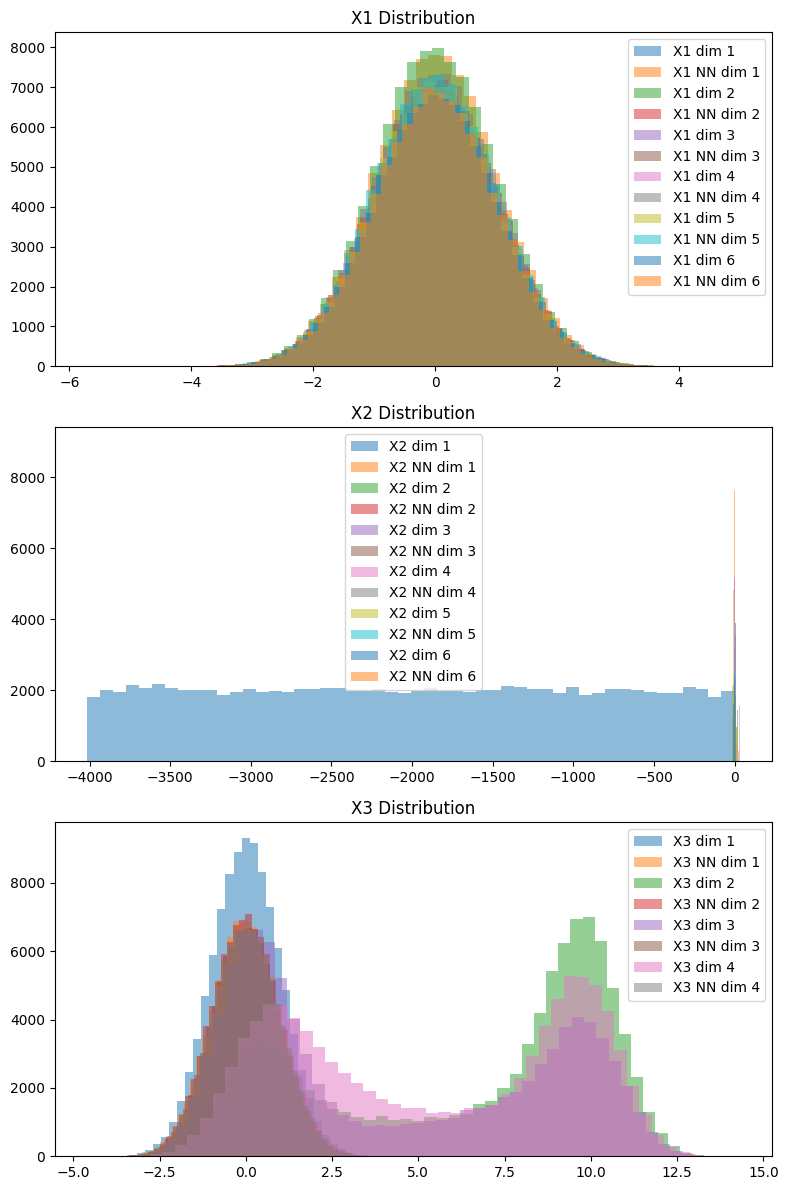

In [131]:
import matplotlib.pyplot as plt

# Function to sample from a trained neural network
def sample_from_nn(model, num_samples):
    with torch.no_grad():
        samples = model(torch.randn(num_samples, 6 if model == nf_X1 else 6 if model == nf_X2 else 4))
    return samples.numpy()

# Sample from each neural network
X1_samples_nn = sample_from_nn(nf_X1, 100000)
X2_samples_nn = sample_from_nn(nf_X2, 100000)
X3_samples_nn = sample_from_nn(nf_X3_given_X1_X2, 100000)

# Plot the samples on top of the training data
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

for i in range(6):
    axs[0].hist(X1_samples[:, i], bins=50, alpha=0.5, label=f'X1 dim {i+1}')
    axs[0].hist(X1_samples_nn[:, i], bins=50, alpha=0.5, label=f'X1 NN dim {i+1}')
axs[0].legend()
axs[0].set_title('X1 Distribution')

for i in range(6):
    axs[1].hist(X2_samples[:, i], bins=50, alpha=0.5, label=f'X2 dim {i+1}')
    axs[1].hist(X2_samples_nn[:, i], bins=50, alpha=0.5, label=f'X2 NN dim {i+1}')
axs[1].legend()
axs[1].set_title('X2 Distribution')

for i in range(4):
    axs[2].hist(X3_input[:, i], bins=50, alpha=0.5, label=f'X3 dim {i+1}')
    axs[2].hist(X3_samples_nn[:, i], bins=50, alpha=0.5, label=f'X3 NN dim {i+1}')
axs[2].legend()
axs[2].set_title('X3 Distribution')

plt.tight_layout()
plt.show()

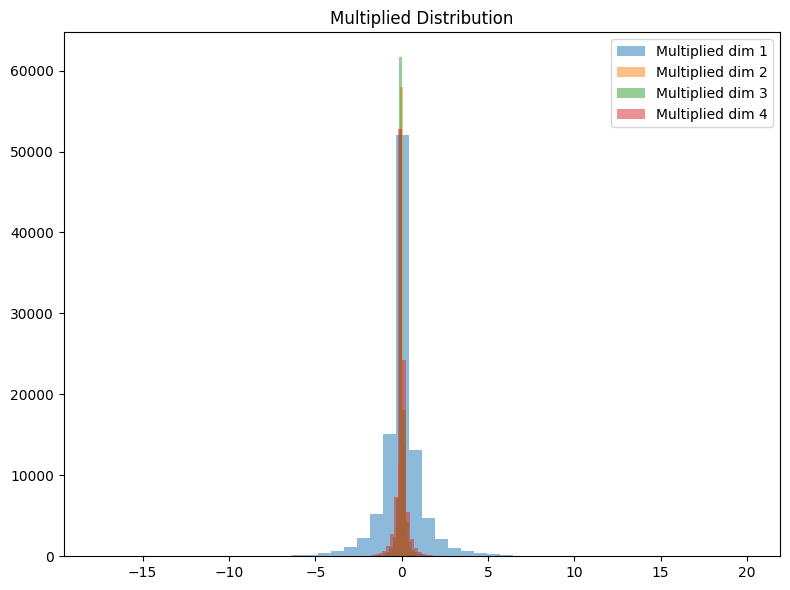

In [127]:
X1_samples_adjusted = X1_samples_nn[:, :4]  # Select first 4 dimensions to match X3
X2_samples_adjusted = X2_samples_nn[:,:4]

# Multiply samples from all three distributions together
X_mult_all = X1_samples_adjusted * X2_samples_adjusted * X3_samples_nn

# Plot the result
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.hist(X_mult_all[:, i], bins=50, alpha=0.5, label=f'Multiplied dim {i+1}')
plt.legend()
plt.title('Multiplied Distribution')
plt.tight_layout()
plt.show()

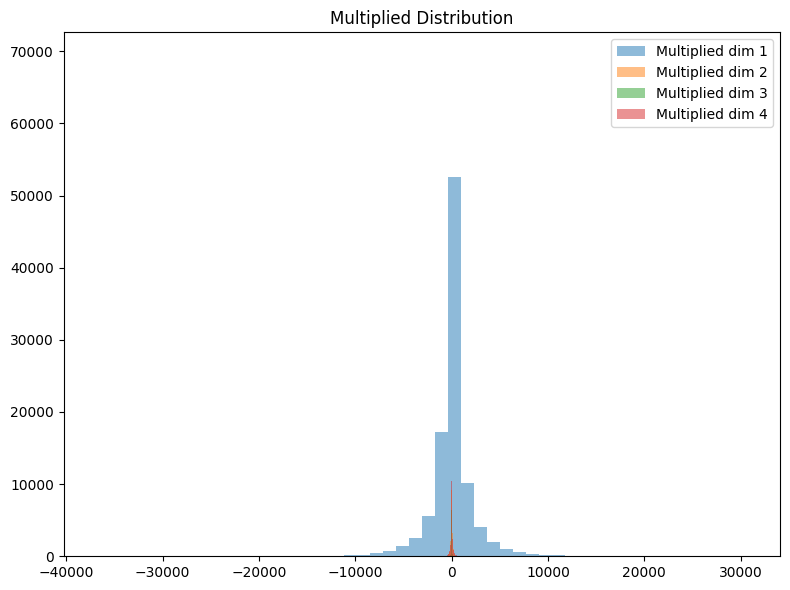

In [129]:
X1_samples_adjustedreal = X1_samples[:, :4]  # Select first 4 dimensions to match X3
X2_samples_adjustedreal = X2_samples[:,:4]

# Multiply samples from all three distributions together
X_mult_all = X1_samples_adjustedreal * X2_samples_adjustedreal * X3_input.numpy()

# Plot the result
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.hist(X_mult_all[:, i], bins=50, alpha=0.5, label=f'Multiplied dim {i+1}')
plt.legend()
plt.title('Multiplied Distribution')
plt.tight_layout()
plt.show()

Another look: Just one cross section of the non-product distribution (i.e., "pure" X3)

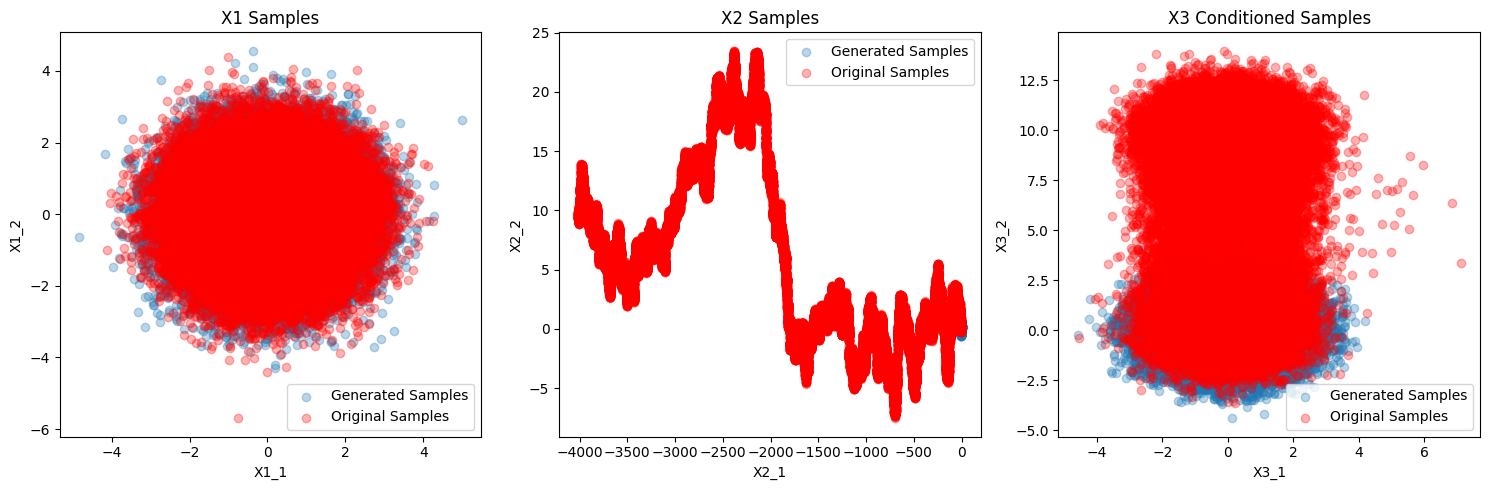

In [133]:
plt.figure(figsize=(15, 5))

# Plotting X1 samples
plt.subplot(1, 3, 1)
plt.scatter(X1_samples_nn[:, 0], X1_samples_nn[:, 1], alpha=0.3, label='Generated Samples')
plt.scatter(X1_samples[:, 0], X1_samples[:, 1], alpha=0.3, color='red', label='Original Samples')
plt.title('X1 Samples')
plt.xlabel('X1_1')
plt.ylabel('X1_2')
plt.legend()

# Plotting X2 samples
plt.subplot(1, 3, 2)
plt.scatter(X2_samples_nn[:, 0], X2_samples_nn[:, 1], alpha=0.3, label='Generated Samples')
plt.scatter(X2_samples[:, 0], X2_samples[:, 1], alpha=0.3, color='red', label='Original Samples')
plt.title('X2 Samples')
plt.xlabel('X2_1')
plt.ylabel('X2_2')
plt.legend()

# Plotting X3 conditioned samples
plt.subplot(1, 3, 3)
plt.scatter(X3_samples_nn[:, 0], X3_samples_nn[:, 1], alpha=0.3, label='Generated Samples')
plt.scatter(X3_input.numpy()[:, 0], X3_input.numpy()[:, 1], alpha=0.3, color='red', label='Original Samples')
plt.title('X3 Conditioned Samples')
plt.xlabel('X3_1')
plt.ylabel('X3_2')
plt.legend()

plt.tight_layout()
plt.show()